---

# <center> GFootball Stable-Baselines3 </center>

---
<center><img src="https://raw.githubusercontent.com/DLR-RM/stable-baselines3/master/docs/_static/img/logo.png" width="308" height="268" alt="Stable-Baselines3"></center>
<center><small>Image from Stable-Baselines3 repository</small></center>

---
This notebook uses the [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3) library to train a [PPO](https://openai.com/blog/openai-baselines-ppo/) reinforcement learning agent on [GFootball Academy](https://github.com/google-research/football/tree/master/gfootball/scenarios) scenarios, applying the architecture from the paper "[Google Research Football: A Novel Reinforcement Learning Environment](https://arxiv.org/abs/1907.11180)".

In [1]:
%%bash
# dependencies
apt-get -y update > /dev/null
apt-get -y install libsdl2-gfx-dev libsdl2-ttf-dev > /dev/null

# cloudpickle, pytorch, gym
pip3 install "cloudpickle==1.3.0"
pip3 install "torch==1.5.1"
pip3 install "gym==0.17.2"

# gfootball
GRF_VER=v2.8
GRF_PATH=football/third_party/gfootball_engine/lib
GRF_URL=https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_${GRF_VER}.so
git clone -b ${GRF_VER} https://github.com/google-research/football.git
mkdir -p ${GRF_PATH}
wget -q ${GRF_URL} -O ${GRF_PATH}/prebuilt_gameplayfootball.so
cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . && cd ..

# kaggle-environments
git clone https://github.com/Kaggle/kaggle-environments.git
cd kaggle-environments && pip3 install . && cd ..

# stable-baselines3
git clone https://github.com/DLR-RM/stable-baselines3.git
cd stable-baselines3 && pip3 install . && cd ..

# housekeeping
# rm -rf football kaggle-environments stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gym: filename=gym-0.17.2-py3-none-any.whl size=1650890 sha256=eead44908dc501b0c4d88b1e30f9799beb28f55f0cd71c903bb0959a1d2f24e1
  Stored in directory: /root/.cache/pip/wheels/18/e1/58/89a2aa24e6c2cc800204fc02010612afdf200926c4d6bfe315
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /con

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
Cloning into 'football'...
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Cloning into 'kaggle-environments'...
  DEPRECATION: A future pip version will change local packages to be built in-plac

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/RL/Final_project/Colab')




Mounted at /content/drive


In [3]:
import os
import base64
import pickle
import zlib
import gym
import numpy as np
import pandas as pd
import torch as th
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from torch import nn, tensor
from collections import deque
from gym.spaces import Box, Discrete
from kaggle_environments import make
from kaggle_environments.envs.football.helpers import *
from gfootball.env import create_environment, observation_preprocessing
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from IPython.display import HTML
from visualizer import visualize

from matplotlib import pyplot as plt
%matplotlib inline

opponentpath="/content/drive/MyDrive/RL/Final_project/Colab/opponent/"
for filename in os.listdir(opponentpath):
  fullpath = opponentpath+filename
  !cp -r $fullpath /content/football/gfootball/scenarios

!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . && cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/football
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for gfootball: filename=gfootball-2.8-cp37-cp37m-linux_x86_64.whl size=38785536 sha256=90b6d834a57411a6b03b68a34854386400de25cbd6a44a9a8319e2f37e554e58
  Stored in directory: /tmp/pip-ephem-wheel-cache-xbxpfe0q/wheels/bb/c2/92/82a23d0c207f5497a23f4316675eb1629e6be474bd2c3be61a
Successfully built gfootball
  Attempting uninstall: gfootball
    Found existing installation: gfootball 2.8
    Uninstalling gfootball-2.8:
      Successfully uninstalled gfootball

In [4]:
# prev_obs is the obs before the action is taken, obs is the next obs as a result of the action.
def reward_modifier(rew, action, prev_obs, obs):
  
  ball_x, ball_y, ball_z = obs['ball']
  MIDDLE_X, PENALTY_X, END_X = 0.2, 0.64, 1.0
  PENALTY_Y, END_Y = 0.27, 0.42

  # Ball position
  ball_position_r = 0.0
  if   (-END_X <= ball_x    and ball_x < -PENALTY_X)and (-PENALTY_Y < ball_y and ball_y < PENALTY_Y):
      ball_position_r = -2.0
  elif (-END_X <= ball_x    and ball_x < -MIDDLE_X) and (-END_Y < ball_y     and ball_y < END_Y):
      ball_position_r = -1.0
  elif (-MIDDLE_X <= ball_x and ball_x <= MIDDLE_X) and (-END_Y < ball_y     and ball_y < END_Y):
      ball_position_r = 0.0
  elif (PENALTY_X < ball_x  and ball_x <=END_X)     and (-PENALTY_Y < ball_y and ball_y < PENALTY_Y):
      ball_position_r = 2.0
  elif (MIDDLE_X < ball_x   and ball_x <=END_X)     and (-END_Y < ball_y     and ball_y < END_Y):
      ball_position_r = 1.0
  else:
      ball_position_r = 0.0

  # Yellow card 
  left_yellow = np.sum(obs["left_team_yellow_card"]) -  np.sum(prev_obs["left_team_yellow_card"])
  right_yellow = np.sum(obs["right_team_yellow_card"]) -  np.sum(prev_obs["right_team_yellow_card"])
  yellow_r = right_yellow - left_yellow
  
  # Score 
  win_reward = 0.0
  if obs['steps_left'] == 0:
      [my_score, opponent_score] = obs['score']
      if my_score > opponent_score:
          win_reward = 1.0

  # Stealing of ball
  # loses ball to opponent
  steal_r = 0
  if (prev_obs['ball_owned_team'] == 0) and (obs['ball_owned_team'] == 1):
    steal_r = -1
  # steals ball
  elif (prev_obs['ball_owned_team'] == 1) and (obs['ball_owned_team'] == 0):
    steal_r = 1
  elif (prev_obs['ball_owned_team'] == -1) and (obs['ball_owned_team'] == 0):
    steal_r = 0.5
  elif (prev_obs['ball_owned_team'] == -1) and (obs['ball_owned_team'] == 1):
    steal_r = -0.5

  possession_r = 0
  if(obs['ball_owned_team'] == 0):
    possession_r = 1
  if(obs['ball_owned_team'] == 1):
    possession_r = -1

  # going out of bounds
  outofbounds_r = 0
  if (prev_obs['game_mode'] == 0) and (prev_obs['ball_owned_team'] == 0):
    if (obs['game_mode'] == 2) or (obs['game_mode'] == 4) or (obs['game_mode'] == 5):
      outofbounds_r = -1

  # shooting near opponent penalty box
  shoot_y = 0.21

  prev_ball_x, prev_ball_y, prev_ball_z = prev_obs['ball']
  in_shoot_region = (prev_ball_x > PENALTY_X and prev_ball_y < shoot_y and prev_ball_y > -shoot_y) 
  
  shoot_r = 0
  if (prev_obs['ball_owned_team'] == 0):
    if in_shoot_region and action == 12:
      shoot_r = 1

  corner_given_r = 0
  if (prev_obs['ball_owned_team'] != 1):
    if (obs['game_mode'] == 4) and (obs['ball_owned_team'] == 1):
      corner_given_r = -1

  return 5.0*rew + 5.0*win_reward + 0.002*possession_r + 0.5*yellow_r + 0.01*steal_r + 0.05*outofbounds_r + 0.05*corner_given_r + 0.1*shoot_r



---
# Football Gym
> [Stable-Baselines3: Custom Environments](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html)<br/>
> [SEED RL Agent](https://www.kaggle.com/piotrstanczyk/gfootball-train-seed-rl-agent): stacked observations

In [5]:
class FootballGym(gym.Env):
    spec = None
    metadata = None
    
    def __init__(self, config=None):
        super(FootballGym, self).__init__()
        env_name = "academy_empty_goal_close"
        rewards = "scoring,checkpoints"
        self.reward_mod = True
        if config is not None:
            env_name = config.get("env_name", env_name)
            rewards = config.get("rewards", rewards)
            self.reward_mod = config.get("reward_mod", self.reward_mod)
        self.env = create_environment(
            env_name=env_name,
            stacked=False,
            representation="raw",
            rewards = rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=False,
            render=False,
            write_video=False,
            dump_frequency=1,
            logdir=".",
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0)  
        self.action_space = Discrete(19)
        self.observation_space = Box(low=0, high=255, shape=(72, 96, 16), dtype=np.uint8)
        self.obs_stack = deque([], maxlen=4)
        self.prev_obs = self.observation_space.sample()[0]

  # elif representation == 'simple115':
  #   env = wrappers.Simple115StateWrapper(env)
  # elif representation == 'simple115v2':
  #   env = wrappers.Simple115StateWrapper(env, True)
  # elif representation == 'extracted':
  #   env = wrappers.SMMWrapper(env, channel_dimensions)
  # elif representation == 'raw':

    def transform_obs(self, raw_obs):
        obs = raw_obs[0]
        obs = observation_preprocessing.generate_smm([obs])
        if not self.obs_stack:
            self.obs_stack.extend([obs] * 4)
        else:
            self.obs_stack.append(obs)

        obs = np.concatenate(list(self.obs_stack), axis=-1)
        obs = np.squeeze(obs)
        return obs

    def reset(self):
        self.obs_stack.clear()
        obs = self.env.reset()
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step([action])
        final_reward = reward
        if self.reward_mod == True:
          final_reward = reward_modifier(reward, action, self.prev_obs, obs[0])
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs, float(final_reward), done, info
    
check_env(env=FootballGym(), warn=True)

---
# Football CNN
> [Stable-Baselines3: Custom Policy Network](https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html)<br/>
> [Google Research Football: A Novel Reinforcement Learning Environment](https://arxiv.org/abs/1907.11180)

In [6]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.conv2 = conv3x3(out_channels, out_channels, stride)
        
    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out
    
class FootballCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        in_channels = observation_space.shape[0]  # channels x height x width
        self.cnn = nn.Sequential(
            conv3x3(in_channels=in_channels, out_channels=32),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
          nn.Linear(in_features=52640, out_features=features_dim, bias=True),
          nn.ReLU(),
        )

    def forward(self, obs):
        return self.linear(self.cnn(obs))

---
# PPO Model
> [Stable-Baselines3: PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)<br/>
> [Stable-Baselines3: Vectorized Environments](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html)<br/>
> [Stable-Baselines3: Custom Policy Network](https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html)<br/>
> [GFootball: A Novel Reinforcement Learning Environment](https://arxiv.org/abs/1907.11180)<br/>
> [GFootball: Academy Scenarios](https://github.com/google-research/football/tree/master/gfootball/scenarios)<br/>

In [12]:
filepath = "/content/drive/My Drive/RL/Final_project/trained_agent"
experiment = "gfootball_js4"
log_dir = f"{filepath}/{experiment}"

In [13]:
training_scenarios = {0: "11_vs_11_easy_stochastic",
             1: "11_vs_11_easy_stochastic_2",
             2: "11_vs_11_easy_stochastic_4",
             3: "11_vs_11_stochastic",
             4: "11_vs_11_hard_stochastic_8",
             5: "11_vs_11_hard_stochastic",
             6: "11_vs_11_kaggle",
             7: "lazy_no_early_finish",
             8: "academy_empty_goal_close",
             9: "academy_empty_goal",
             10: "academy_run_to_score",
             11: "academy_run_to_score_with_keeper",
             12: "academy_pass_and_shoot_with_keeper",
             13: "academy_run_pass_and_shoot_with_keeper",
             14: "academy_3_vs_1_with_keeper",
             15: "academy_corner",
             16: "academy_counterattack_easy",
             17: "academy_counterattack_hard",
             18: "academy_single_goal_versus_lazy",
             19: "11_vs_11_kaggle"
}
training_scenario_name = training_scenarios[0]

In [14]:
class FootballActionEnv(gym.ActionWrapper):
  def __init__(self, env):
    gym.ActionWrapper.__init__(self, env)


  def action(self, act):
    obs = self.env.env.env.unwrapped.observation()
    obs = obs[0]
    player_num = obs['active']

    player_pos_x, player_pos_y = obs['left_team'][player_num]
    ball_x, ball_y, ball_z = obs['ball']
    ball_x_relative = ball_x - player_pos_x
    ball_y_relative = ball_y - player_pos_y

    ball_distance = np.linalg.norm([ball_x_relative, ball_y_relative])

    NO_OP, LEFT, TOP_LEFT, TOP, TOP_RIGHT, RIGHT, BOTTOM_RIGHT, BOTTOM, BOTTOM_LEFT, LONG_PASS, HIGH_PASS, SHORT_PASS, SHOT, SPRINT, RELEASE_DIRECTION, \
                          RELEASE_SPRINT, SLIDE, DRIBBLE, RELEASE_DRIBBLE = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
    act_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    act_list[act] = 1
    if obs['ball_owned_team'] == 1: # opponents owning ball
      act_list[LONG_PASS], act_list[HIGH_PASS], act_list[SHORT_PASS], act_list[SHOT], act_list[DRIBBLE] = 0, 0, 0, 0, 0
    elif obs['ball_owned_team'] == -1 and ball_distance > 0.03 and obs['game_mode'] == 0: # Ground ball  and far from me
      act_list[LONG_PASS], act_list[HIGH_PASS], act_list[SHORT_PASS], act_list[SHOT], act_list[DRIBBLE] = 0, 0, 0, 0, 0
    else: # my team owning ball
      act_list[SLIDE] = 0

    # Dealing with sticky actions
    sticky_actions = obs['sticky_actions']
    if sticky_actions[8] == 0:  # sprinting
      act_list[RELEASE_SPRINT] = 0
            
    if sticky_actions[9] == 1:  # dribbling
      act_list[SLIDE] = 0
    else:
      act_list[RELEASE_DRIBBLE] = 0

    if np.sum(sticky_actions[:8]) == 0:
      act_list[RELEASE_DIRECTION] = 0

    ball_x, ball_y, _ = obs['ball']
    if ball_x < 0.5:
      act_list[SHOT] = 0
    elif (0.64 <= ball_x and ball_x<=1.0) and (-0.27<=ball_y and ball_y<=0.27):
      act_list[HIGH_PASS], act_list[LONG_PASS] = 0, 0

    if obs['game_mode'] == 2 and ball_x < -0.7:  # Our GoalKick 
      if act != LONG_PASS and act != HIGH_PASS and act != SHORT_PASS:
        return 0
      else:
        return act
      # act = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      # act[LONG_PASS], act[HIGH_PASS], act[SHORT_PASS] = 1, 1, 1

    elif obs['game_mode'] == 4 and ball_x > 0.9:  # Our CornerKick
      if act != LONG_PASS and act != HIGH_PASS and act != SHORT_PASS:
        return 0
      else:
        return act
      # act = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      # act[LONG_PASS], act[HIGH_PASS], act[SHORT_PASS] = 1, 1, 1

    elif obs['game_mode'] == 6 and ball_x > 0.6:  # Our PenaltyKick
      if act != SHOT:
        return 0
      else:
        return act
      # act = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      # act[SHOT] = 1

    if 1 in act_list:
      return act_list.index(1)
    else:
      # idle
      return 0

---
# Training
> [Stable-Baselines3: Examples](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html)<br/>
> [Stable-Baselines3: Callbacks](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)

In [15]:
training_index=0
checkpoint = False

from tqdm.notebook import tqdm

# Callback function to save best model
class SaveonBestandProgressBar(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1, prev_timesteps = 0):
        super(SaveonBestandProgressBar, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.pbar = None
        self.reward_list = []
        self.prev_timesteps = prev_timesteps

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_training_start(self):
        factor = np.ceil(self.locals['total_timesteps'] / self.model.n_steps)
        n = 1
        try:
            n = len(self.training_env.envs)
        except AttributeError:
            try:
                n = len(self.training_env.remotes)
            except AttributeError:
                n = 1
        total = int(self.model.n_steps * factor / n)
        self.pbar = tqdm(total=total)

    def _on_rollout_start(self):
        self.pbar.refresh()
    
    def _on_step(self):
        # plot the average reward of the last 100 episodes
        if self.n_calls % 100 == 0:
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              mean_reward = np.mean(y[-100:])
              self.reward_list.append(mean_reward)
        self.pbar.update(1)
        if self.n_calls % self.check_freq == 0:
          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps + self.prev_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  self.save_path = os.path.join(log_dir, '{}'.format(self.prev_timesteps + self.num_timesteps), 'best_model')
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

    def _on_rollout_end(self):
        self.pbar.refresh()

    def _on_training_end(self):
        self.pbar.close()
        self.pbar = None

Callbacktinst = SaveonBestandProgressBar(check_freq=10000, log_dir=log_dir)

In [16]:
n_envs = 4
config={"env_name":training_scenario_name, "rewards":"scoring,checkpoints", "reward_mod": True}
# train_env = DummyVecEnv([make_env(config, rank=i) for i in range(n_envs)])
# train_env = SubprocVecEnv([make_env(config, rank=i) for i in range(n_envs)])
train_env = make_vec_env(FootballGym,n_envs=n_envs,env_kwargs=dict(config=config),monitor_dir=log_dir,wrapper_class=FootballActionEnv)

n_steps = 512
policy_kwargs = dict(features_extractor_class=FootballCNN,
                     features_extractor_kwargs=dict(features_dim=256))
model = PPO(CnnPolicy, train_env, 
            policy_kwargs=policy_kwargs, 
            learning_rate=0.000343, 
            n_steps=n_steps, 
            batch_size=8, 
            n_epochs=2, 
            gamma=0.993,
            gae_lambda=0.95,
            clip_range=0.08, 
            ent_coef=0.003, 
            vf_coef=0.5, 
            max_grad_norm=0.64, 
            verbose=2,
            tensorboard_log=f"{filepath}/tensorboard_js4")

total_timesteps = 1e6

model.learn(total_timesteps=total_timesteps, callback=Callbacktinst, log_interval=None)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to /content/drive/My Drive/RL/Final_project/trained_agent/tensorboard_js4/PPO_1


  0%|          | 0/250112 [00:00<?, ?it/s]

Num timesteps: 40000
Best mean reward: -inf - Last mean reward per episode: -9.89
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/40000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/40000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 80000
Best mean reward: -9.89 - Last mean reward per episode: -11.36
Num timesteps: 120000
Best mean reward: -9.89 - Last mean reward per episode: -10.42
Num timesteps: 160000
Best mean reward: -9.89 - Last mean reward per episode: -8.91
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/160000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/160000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 200000
Best mean reward: -8.91 - Last mean reward per episode: -8.14
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/200000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/200000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 240000
Best mean reward: -8.14 - Last mean reward per episode: -7.78
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/240000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/240000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 280000
Best mean reward: -7.78 - Last mean reward per episode: -7.25
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/280000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/280000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 320000
Best mean reward: -7.25 - Last mean reward per episode: -7.29
Num timesteps: 360000
Best mean reward: -7.25 - Last mean reward per episode: -6.91
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/360000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/360000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 400000
Best mean reward: -6.91 - Last mean reward per episode: -6.13
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/400000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/400000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 440000
Best mean reward: -6.13 - Last mean reward per episode: -5.79
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/440000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/440000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 480000
Best mean reward: -5.79 - Last mean reward per episode: -5.71
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/480000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/480000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 520000
Best mean reward: -5.71 - Last mean reward per episode: -5.79
Num timesteps: 560000
Best mean reward: -5.71 - Last mean reward per episode: -5.66
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/560000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/560000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 600000
Best mean reward: -5.66 - Last mean reward per episode: -5.86
Num timesteps: 640000
Best mean reward: -5.66 - Last mean reward per episode: -4.68
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/640000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/640000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 680000
Best mean reward: -4.68 - Last mean reward per episode: -4.28
Saving new best model to /content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/680000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/RL/Final_project/trained_agent/gfootball_js4/680000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 720000
Best mean reward: -4.28 - Last mean reward per episode: -4.60
Num timesteps: 760000
Best mean reward: -4.28 - Last mean reward per episode: -4.46
Num timesteps: 800000
Best mean reward: -4.28 - Last mean reward per episode: -4.63
Num timesteps: 840000
Best mean reward: -4.28 - Last mean reward per episode: -4.74
Num timesteps: 880000
Best mean reward: -4.28 - Last mean reward per episode: -4.87
Num timesteps: 920000
Best mean reward: -4.28 - Last mean reward per episode: -4.77
Num timesteps: 960000
Best mean reward: -4.28 - Last mean reward per episode: -4.90
Num timesteps: 1000000
Best mean reward: -4.28 - Last mean reward per episode: -4.82


In [ ]:
# total_timesteps = 1e7

# model = PPO.load(Callbacktinst.save_path, train_env, verbose=2)
# Callbacktinst = SaveonBestandProgressBar(check_freq=10000, log_dir=log_dir, prev_timesteps = )  # 이 Cell 만 반복해서 실행해주면 됨 (prev_timesteps 만 update 해주면서)
# model.learn(total_timesteps=total_timesteps, callback=Callbacktinst, log_interval=None)

In [ ]:
# t_scenario_name = training_scenarios[0]
# t_config={"env_name":t_scenario_name}
# t_train_env = make_vec_env(FootballGym,n_envs=4,env_kwargs=dict(config=t_config),monitor_dir=log_dir)
# model.set_env(t_train_env)
# print(vars(model.env.envs[0].env.env).keys())


dict_keys(['reward_mod', 'env', 'action_space', 'observation_space', 'obs_stack', 'prev_obs'])
Logging to /content/drive/My Drive/final_training/tensorboard/PPO_5


  0%|          | 0/5120 [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "{filepath}/tensorboard"

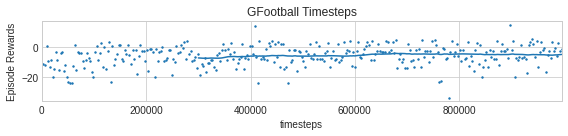

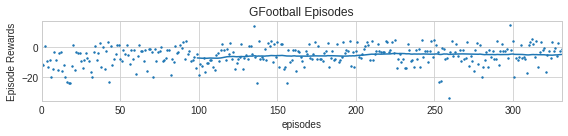

In [17]:
plt.style.use(['seaborn-whitegrid'])
results_plotter.plot_results([log_dir], total_timesteps, results_plotter.X_TIMESTEPS, "GFootball Timesteps")
results_plotter.plot_results([log_dir], total_timesteps, results_plotter.X_EPISODES, "GFootball Episodes")

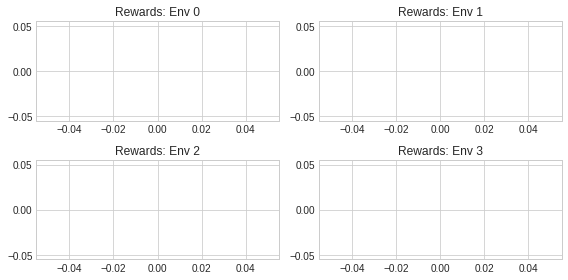

In [18]:
plt.style.use(['seaborn-whitegrid'])
log_files = [os.path.join(log_dir, f"{i}.monitor.csv") for i in range(n_envs)]

nrows = np.ceil(n_envs/2)
fig = plt.figure(figsize=(8, 2 * nrows))
for i, log_file in enumerate(log_files):
    if os.path.isfile(log_file):
        df = pd.read_csv(log_file, skiprows=1)
        plt.subplot(nrows, 2, i+1, label=log_file)
        df['r'].rolling(window=100).mean().plot(title=f"Rewards: Env {i}")
        plt.tight_layout()
plt.show()